## WordCloud Time

In [15]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

In [16]:
df=pd.read_csv('C://Users/William Jiang/Downloads/TwitterSentimentByCountry.csv')

In [3]:
df['file_name'].unique()

array(['Japan', 'Albania', 'Mexico', 'Mozambique', 'Bahamas',
       'Guadeloupe', 'Barbados', 'United Arab Emirates',
       'Marshall Islands', 'Kuwait', 'Ethiopia', 'Gabon', 'Austria',
       'Somalia', 'Senegal', 'Georgia', 'Zimbabwe', 'Tonga',
       'Czech Republic', 'Taiwan', 'Uzbekistan', 'Dominican Republic',
       'Madagascar', 'Ukraine', 'Qatar', 'Turkmenistan', 'Monaco', 'USA',
       'Andorra', 'Slovenia', 'Spain', 'Paraguay', 'HongKong',
       'Afghanistan', 'Germany', 'El Salvador', 'Bosnia', 'Canada',
       'Anguilla', 'Uruguay', 'Honduras', 'Equatorial Guinea',
       'Luxembourg', 'Israel', 'Argentina', 'Guatemala', 'Brazil',
       'Kenya', 'Serbia', 'Papua New Guinea', 'Russia', 'Finland',
       'UnitedKingdom', 'Poland', 'Togo', 'Bermuda', 'Samoa',
       'Phillippines', 'Tajikistan', 'Vietnam', 'Latvia', 'NewZealand',
       'Costa Rica', 'Trinidad and Tobago', 'Estonia', 'Cambodia',
       'Morocco', 'Slovakia', 'Gambia', 'Nepal', 'Bhutan', 'Egypt',
       'N

In [5]:
dfAustralia=df[df['file_name']=='Australia']
dfChina=df[df['file_name']=='China']
dfUSA=df[df['file_name']=='USA']
dfJapan=df[df['file_name']=='Japan']
dfIraq=df[df['file_name']=='Iraq']

In [128]:
dfRussia=df[df['file_name']=='Russia']

In [19]:
dfTanzania=df[df['file_name']=='Tanzania']

## WordCloud without filtering out stopwords and stopchars

There are 3792033 words in the combination of all tweets.


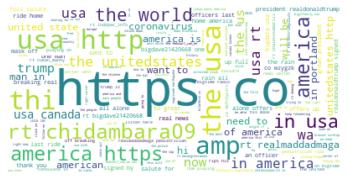

In [31]:
dfWordCloud=dfUSA
stopwords = set(STOPWORDS)
stopwords.update(["rt","https","https."])
text = " ".join(tweet.lower() for tweet in dfWordCloud.text)
print ("There are {} words in the combination of all tweets.".format(len(text)))
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## WordCloud with stopword and stopchar filtering

In [22]:
##Count frequencies of words
##Removes the stop words and characters
stop_words = set(stopwords.words('english'))
stop_char=['#','@']
stop_words.update(["rt","https","https.","-",'.',':'])
dfWordCloud=dfTanzania
text = " ".join(tweet.lower() for tweet in dfWordCloud.text)
all_freq={}
for word in text.split():
    res = [char for char in stop_char if(char in word)]
    if len(res)==0:
        if word not in stop_words:
            if word in all_freq: 
                all_freq[word] += 1
            else: 
                all_freq[word] = 1    
            

In [139]:
s = pd.Series(all_freq, name='count')
s.index.name = 'word'
sdf=s.reset_index()
sdf=sdf.sort_values('count',ascending=False)

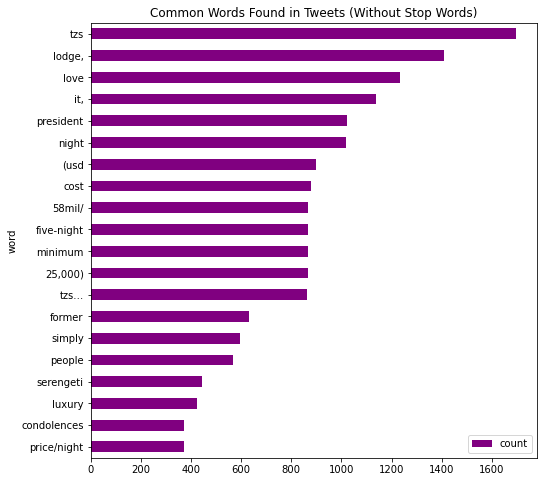

In [140]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
sdf[0:20].sort_values(by='count').plot.barh(x='word',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.show()

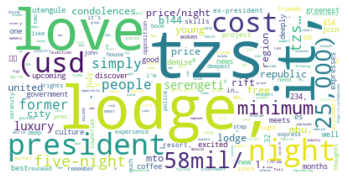

In [141]:
##Generate wordcloud from frequencies
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate_from_frequencies(all_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Add in a For Loop for all Countries and pipe it to a dataframe for output
Take the First 20 most popular words and put in json 

## Actually lets rewrite this as a custom pandas function

In [19]:
## Custome Aggregation function. takes in numpy array
def word_freq(arr):
    stop_words = set(stopwords.words('english'))
    stop_char=['#','@','&']
    stop_words.update(["rt","https","https.","-",'.',':'])
    text = " ".join(tweet.lower() for tweet in arr)
    all_freq={}
    for word in text.split():
        res = [char for char in stop_char if(char in word)]
        if len(res)==0:
            if word not in stop_words:
                if word in all_freq: 
                    all_freq[word] += 1
                else: 
                    all_freq[word] = 1   
    word_freq_list=sorted(all_freq.items(), key=lambda x: x[1],reverse=True)[0:30]
    return word_freq_list

In [17]:
## Test with one created_at time
dftest=df[df['created_at'].str.contains("2020-07-20")]
# dftest=df[( (df['file_name']=='Australia') | (df['file_name']=='China') )& (df['created_at'].str.contains("2020-07-20"))]

In [23]:
df_word_freq_groupby=dftest.groupby(['partition_1','partition_0'])['text'].agg([word_freq,'count'])

In [26]:
df_word_freq_groupby['count'].sum()

162870

In [103]:
df_word_freq_groupby=dftest.groupby(['partition_1','partition_0'])['text'].agg(word_freq).to_frame()
df_avg_groupby=dftest.groupby(['partition_1','partition_0'])['polarity','followers','friends','retweet_count'].mean()
df_final_agg=df_avg_groupby.join(df_word_freq_groupby, on=['partition_1','partition_0'])
df_final_agg=df_final_agg.rename(columns={"text": "word_freq_list"})

In [105]:
df_final_agg.to_csv('df_final_agg.csv')

## Lets query our datalake via Athena

In [11]:
import pythena
import datetime
import json
import s3fs

athena_client = pythena.Athena("twitterappdatalake",region="ap-southeast-2") 

# Returns results as a pandas dataframe
string_date='2020-07-20'



In [12]:
with open("C:/Users/William Jiang/Documents/credentials.json") as f:
    d = json.load(f)
    cred_json=d["twitter_api"]
    s3_cred_json=d["s3-access"]
    
##auth using s3fs
fs = s3fs.S3FileSystem(anon=False, key=s3_cred_json['ACCESS_KEY_ID'], secret=s3_cred_json['SECRET_ACCESS_KEY'])

In [5]:
today_date = datetime.date.today()
string_today=today_date.strftime("%Y-%m-%d")

In [ ]:
string_query='''
SELECT * FROM twitterdatalake t where date(date_parse(created_at,'%Y-%m-%d %H:%i:%s'))=date_parse('{0}','%Y-%m-%d')
'''.format(string_date)
df_oneday = athena_client.execute(string_query)

In [111]:
dftest=df_oneday[0]

In [112]:
df_word_freq_groupby=dftest.groupby(['partition_1','partition_0'])['text'].agg(word_freq).to_frame()
df_avg_groupby=dftest.groupby(['partition_1','partition_0'])['polarity','followers','friends','retweet_count'].mean()
df_final_agg=df_avg_groupby.join(df_word_freq_groupby, on=['partition_1','partition_0'])
df_final_agg=df_final_agg.rename(columns={"text": "word_freq_list"})

In [113]:
df_final_agg.to_csv('df_final_agg_real.csv')